In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score
from medmnist import ChestMNIST
from PIL import Image

In [1]:
def load_data(data_split, image_nxn_size, n_observations):
    data = ChestMNIST(split=data_split, download=True, size=image_nxn_size)

    if n_observations > 0:
        images = data.imgs[0:n_observations]
        labels = data.labels[0:n_observations]
    else:      
        images = data.imgs
        labels = data.labels

    del data

    return images, labels

In [4]:
train_images, train_labels = load_data(data_split="train", image_nxn_size=224, n_observations=1000)
validation_images, validation_labels = load_data(data_split="val", image_nxn_size=224, n_observations=1000)
test_images, test_labels = load_data(data_split="test", image_nxn_size=224, n_observations=1000)

Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist_224.npz
Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist_224.npz
Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist_224.npz


In [5]:
def preprocess_data(image_set):
    preprocess = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformed_images = []

    for image in tqdm.tqdm(image_set):
        image = np.float32(image) / 255.0
        image = Image.fromarray(image)
        transformed_images.append(preprocess(image))

    return torch.stack(transformed_images)

In [6]:
x_train_tensor = preprocess_data(train_images)
x_validation_tensor = preprocess_data(validation_images)
x_test_tensor = preprocess_data(test_images)

100%|██████████| 1000/1000 [00:00<00:00, 1279.42it/s]


In [7]:
# Debugging
# num_images = len(transformed_images)
# image_size = transformed_images[0].numel()  # Number of elements in one image
# dtype_size = transformed_images[0].element_size()  # Size of each element in bytes
# total_memory = num_images * image_size * dtype_size
# print(f"Total memory required: {total_memory / (1024 ** 3):.2f} GB")

In [8]:
y_train_tensor = torch.tensor(train_labels)
y_validation_tensor = torch.tensor(validation_labels)
y_test_tensor = torch.tensor(test_labels)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(x_validation_tensor, y_validation_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders for efficient training and testing data handling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  

In [38]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT, progress=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, train_labels.shape[1], bias=True)

In [10]:
optimizer = optim.Adam(model.parameters(), lr = 0.1)
#scheduler = StepLR(optimizer, step_size = 2, gamma = 0.5)
criterion = nn.BCEWithLogitsLoss()

In [40]:
best_model_path = "best_transfer_learning_model.pth"
best_loss = np.inf
best_score = 0
best_epoch = 0
sigmoid_threshold = 0.5

for epoch in range(5):
    model.train()
    
    for inputs, targets in tqdm.tqdm(train_loader, desc="Training: "):
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.float()

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    all_targets = []
    all_predictions = []
    validation_loss = 0.0
    validation_accuracy = 0.0
    
    with torch.no_grad():
        for validation_inputs, validation_targets in validation_loader:
            validation_outputs = model(validation_inputs)
            validation_targets = validation_targets.float()
            validation_loss += criterion(validation_outputs, validation_targets)

            probabilities = torch.sigmoid(validation_outputs)
            predictions = (probabilities > sigmoid_threshold).float()

            all_targets.extend(validation_targets)
            all_predictions.extend(predictions)

    validation_score = average_precision_score(all_targets, all_predictions, average="macro")
    validation_loss /= len(validation_loader.dataset)

    if validation_loss < best_loss:
        best_loss = validation_loss
    
    if validation_score > best_score:
        best_score = validation_score
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch: {epoch + 1}, Validation Loss: {validation_loss}, Macro Average Precision: {validation_score}")

Training: 100%|██████████| 16/16 [01:07<00:00,  4.20s/it]


Epoch: 1, Validation Loss: 0.013638503849506378, Macro Average Precision: 0.04885714285714286


Training: 100%|██████████| 16/16 [01:14<00:00,  4.65s/it]


Epoch: 2, Validation Loss: 0.01408355962485075, Macro Average Precision: 0.04892577030812325


Training: 100%|██████████| 16/16 [01:11<00:00,  4.50s/it]


Epoch: 3, Validation Loss: 0.013290677219629288, Macro Average Precision: 0.04885714285714286


Training: 100%|██████████| 16/16 [01:09<00:00,  4.34s/it]


Epoch: 4, Validation Loss: 0.014572257176041603, Macro Average Precision: 0.04885714285714286


Training: 100%|██████████| 16/16 [01:10<00:00,  4.43s/it]


Epoch: 5, Validation Loss: 0.013722668401896954, Macro Average Precision: 0.04885714285714286


In [41]:
model.load_state_dict(torch.load("best_transfer_learning_model.pth", weights_only=True))
model.eval()

all_targets = []
all_predictions = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_targets in tqdm.tqdm(test_loader, desc="Testing:"):
        test_outputs = model(test_inputs)
        test_targets = test_targets.float()
        test_loss += criterion(test_outputs, test_targets)

        probabilities = torch.sigmoid(test_outputs)
        predictions = (probabilities > sigmoid_threshold).float()

        all_targets.extend(test_targets)
        all_predictions.extend(predictions)

#print(all_predictions)
test_loss /= len(validation_loader.dataset)
test_hamming_loss = hamming_loss(all_targets, all_predictions)
test_accuracy = accuracy_score(all_targets, all_predictions)
test_precision = precision_score(all_targets, all_predictions, average="micro")
test_recall = recall_score(all_targets, all_predictions, average="micro")
test_f1_score = f1_score(all_targets, all_predictions, average="micro")
test_roc_auc = roc_auc_score(all_targets, all_predictions)

print(f"Test Loss: {test_loss}")
print(f"Hamming Loss: {test_hamming_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1_score}")
print(f"ROC AUC: {test_roc_auc}")


Testing:: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it]

Test Loss: 0.01410981360822916
Hamming Loss: 0.585
Accuracy: 0.0
Precision: 0.034448327508736894
Recall: 0.3780821917808219
F1 Score: 0.06314344543582705
ROC AUC: 0.5003157639802203


In [14]:
# Try using the CNN as a feature extractor for traditional ML methods
# Include a larger classification layer for finetuning
# Address potential class imbalance

In [ ]:
grad_cam_image[0][0].shape

torch.Size([1024, 1024])

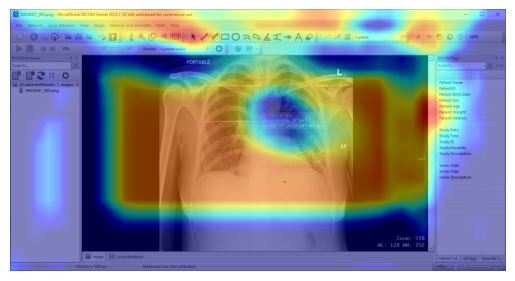

In [50]:
model.eval()

preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

example_image = Image.open("Capture.PNG").convert("L")
grad_cam_image = np.float32(example_image) / 255.0
grad_cam_image = Image.fromarray(grad_cam_image)

target_layers = [model.layer4[-1]]
input_tensor = preprocess(grad_cam_image).unsqueeze(0)

labels = [6]
targets = [ClassifierOutputTarget(label) for label in labels]

with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  grayscale_cam = grayscale_cam[0, :]
  
  img = np.float32(example_image) / 255.0
  img = np.repeat(img[..., np.newaxis], 3, axis=-1)
  visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

  #model_outputs = cam.outputs

plt.imshow(visualization)
plt.axis("off")
plt.show()